## Plot a cross-section of potential temperature and wind speed from HRRR hybrid-level data

### Gets data from the AWS HRRR S3 archive, and various MetPy tools for constructing the cross-section

In [1]:
import fsspec
import xarray as xr

import metpy.calc as mpcalc
from metpy.interpolate import cross_section
from metpy.units import units
from metpy.plots import USCOUNTIES

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd


#### Get HRRR native (hybrid) level data from the AWS S3 archive. This will take a while when first running, as it's pulling in a fairly large HRRR file from the cloud. But no need to permanently take up a bunch of disk space with downloaded files!

Supply the model initialization date and time, and also the forecast hour


In [2]:
## define desired initialization time and forecast time
hrrr_init = pd.Timestamp(2021,12,30,15)  ## YYYYMMDDHH
fcst_lead = 7 ## number of hours 

In [3]:
%%time

### based on: https://stackoverflow.com/questions/66229140/xarray-read-remote-grib-file-on-s3-using-cfgrib

#uri = "simplecache::s3://noaa-hrrr-bdp-pds/hrrr.20211230/conus/hrrr.t12z.wrfnatf08.grib2"
uri = "simplecache::s3://noaa-hrrr-bdp-pds/hrrr."+hrrr_init.strftime("%Y%m%d")+"/conus/hrrr.t"+hrrr_init.strftime("%H")+"z.wrfnatf"+str(fcst_lead).zfill(2)+".grib2"
print(uri)

file = fsspec.open_local(uri, s3={'anon': True}, filecache={'cache_storage':'/tmp/files'})

### get hybrid-level data (apparently it's only possible to get all variables, or a single variable, for a level type with cfgrib)
t_in = xr.open_dataset(file, engine="cfgrib",
                    backend_kwargs={'filter_by_keys':{'typeOfLevel': 'hybrid',
                                                     'shortName':'t'}
                                   })

p_in = xr.open_dataset(file, engine="cfgrib",
                    backend_kwargs={'filter_by_keys':{'typeOfLevel': 'hybrid',
                                                     'shortName':'pres'}
                                   })

u_in = xr.open_dataset(file, engine="cfgrib",
                    backend_kwargs={'filter_by_keys':{'typeOfLevel': 'hybrid',
                                                     'shortName':'u'}
                                   })

v_in = xr.open_dataset(file, engine="cfgrib",
                    backend_kwargs={'filter_by_keys':{'typeOfLevel': 'hybrid',
                                                     'shortName':'v'}
                                   })

hgt_in = xr.open_dataset(file, engine="cfgrib",
                    backend_kwargs={'filter_by_keys':{'typeOfLevel': 'hybrid',
                                                     'shortName':'gh'}
                                   })

### and surface pressure 
psfc_in = xr.open_dataset(file, engine="cfgrib",
                    backend_kwargs={'filter_by_keys':{'typeOfLevel': 'surface',
                                    'stepType':'instant', 'shortName': 'sp'}
                                   })

### and surface height 
zsfc_in = xr.open_dataset(file, engine="cfgrib",
                    backend_kwargs={'filter_by_keys':{'typeOfLevel': 'surface',
                                    'stepType':'instant', 'shortName': 'orog'}
                                   })

### and u/v at 80 m (note that if we want 10-m wind, just change u to 10u)
u80_in = xr.open_dataset(file, engine="cfgrib",
                    backend_kwargs={'filter_by_keys':{'typeOfLevel': 'heightAboveGround',
                                    'stepType':'instant', 'shortName': 'u'}
                                   })
v80_in = xr.open_dataset(file, engine="cfgrib",
                    backend_kwargs={'filter_by_keys':{'typeOfLevel': 'heightAboveGround',
                                    'stepType':'instant', 'shortName': 'v'}
                                   })

simplecache::s3://noaa-hrrr-bdp-pds/hrrr.20211230/conus/hrrr.t15z.wrfnatf07.grib2
CPU times: user 7.18 s, sys: 2.38 s, total: 9.56 s
Wall time: 25.7 s


#### merge the hybrid-level data and surface data all together into a single dataset

In [5]:
## merge these all together into a single dataset
data = xr.merge([t_in,p_in,u_in,v_in,hgt_in,psfc_in,zsfc_in])
data_80m = xr.merge([u80_in,v80_in])
#data

#### Get the initialization and valid times from the dataset

In [6]:
init = pd.to_datetime(data.time.values)
vtime = pd.to_datetime(data.valid_time.values)

lead = (data.step / np.timedelta64(1, 'h')).astype(int).values

### assign the grid projection for each dataset, using some of the metadata from the grib file, since this doesn't get done automatically

In [8]:
data_subset = data.metpy.assign_crs(
    grid_mapping_name='lambert_conformal_conic',
    latitude_of_projection_origin=data.t.GRIB_LaDInDegrees,
    longitude_of_central_meridian=data.t.GRIB_LoVInDegrees,
    standard_parallel=(data.t.GRIB_Latin1InDegrees,data.t.GRIB_Latin2InDegrees),
    earth_radius=6371229.
).metpy.assign_y_x()

data_80m_subset = data_80m.metpy.assign_crs(
    grid_mapping_name='lambert_conformal_conic',
    latitude_of_projection_origin=data_80m.u.GRIB_LaDInDegrees,
    longitude_of_central_meridian=data_80m.u.GRIB_LoVInDegrees,
    standard_parallel=(data_80m.u.GRIB_Latin1InDegrees,data_80m.u.GRIB_Latin2InDegrees),
    earth_radius=6371229.
).metpy.assign_y_x()

#data_subset

/Users/rschumac/opt/miniforge3/envs/herbie_m1/lib/python3.9/site-packages/metpy/xarray.py:353: UserWarning: More than one time coordinate present for variable "t".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/Users/rschumac/opt/miniforge3/envs/herbie_m1/lib/python3.9/site-packages/metpy/xarray.py:353: UserWarning: More than one time coordinate present for variable "pres".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/Users/rschumac/opt/miniforge3/envs/herbie_m1/lib/python3.9/site-packages/metpy/xarray.py:353: UserWarning: More than one time coordinate present for variable "u".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/Users/rschumac/opt/miniforge3/envs/herbie_m1/lib/python3.9/site-packages/metpy/xarray.py:353: UserWarning: More than one time coordinate present for variable "v".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/Users/rschumac/opt/miniforge3/en

#### calculate potential temperature and wind speed

In [9]:
data_subset['theta'] = mpcalc.potential_temperature(data_subset.pres,data_subset.t)
data_subset['wspd'] = mpcalc.wind_speed(data_subset.u,data_subset.v)
data_80m_subset['wspd'] = mpcalc.wind_speed(data_80m_subset.u,data_80m_subset.v)

#### Define the lat/lon endpoints of our cross-section

In [10]:
start = (39.92,-106.8)
end = (39.92,-103.7)

#### Use MetPy's cross-section method to calculate the quantities along our specified line

In [11]:
cross = cross_section(data_subset, start, end).set_coords(('latitude', 'longitude'))

cross['longitude'] = cross.longitude - 360.
### expand the longitude array dims to allow for plotting of hybrid data
cross['longitude2d'] = cross.longitude.expand_dims({'hybrid':50})

#cross

/Users/rschumac/opt/miniforge3/envs/herbie_m1/lib/python3.9/site-packages/metpy/xarray.py:353: UserWarning: More than one time coordinate present for variable "t".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


### First make a map of the 80-m AGL winds at this time

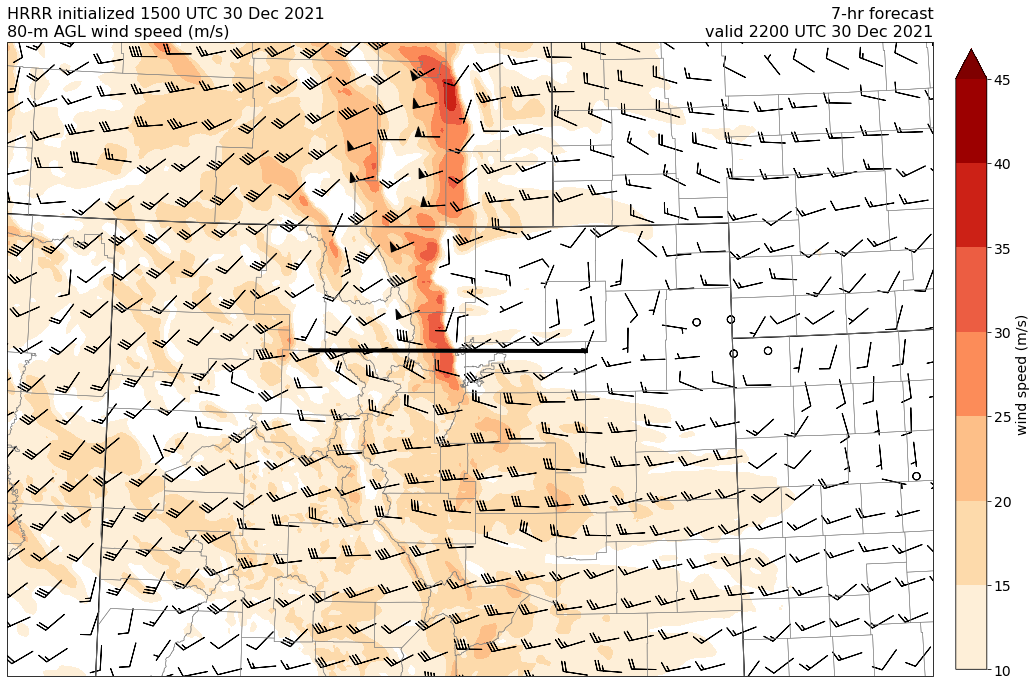

In [12]:
# Set Projection of Plot
fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)
# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=38.5, central_longitude=-105)
ax = plt.subplot(gs[0], projection=plotcrs)
data_crs = data_subset['t'].metpy.cartopy_crs

# Set plot bounds -- or just comment this out if wanting to plot the full domain
ax.set_extent((-110, -100, 37., 42.5))

ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=1)
ax.add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.5, edgecolor='gray')

# Plot Titles
plt.title("HRRR initialized "+init.strftime("%H%M UTC %d %b %Y")+"\n80-m AGL wind speed (m/s)",
          loc='left', fontsize=16)
plt.title(str(lead)+"-hr forecast\nvalid "+vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)


### set levels for wind speed and plot it
levels = [10,15,20,25,30,35,40,45]
#levels = np.arange(10,46,2)

plt.contourf(data_subset.longitude, data_subset.latitude, data_80m_subset.wspd, levels,
             transform=ccrs.PlateCarree(), extend='max', transform_first=True,
             cmap=get_cmap("OrRd"))

# Add the 10-m wind barbs, only plotting every 15th data point.
wind_slice = (slice(None, None, 11), slice(None,None,11))
plt.barbs(data_80m_subset.longitude[wind_slice].values, data_80m_subset.latitude[wind_slice].values,
          data_80m_subset.u[wind_slice].metpy.convert_units('kt').values, 
          data_80m_subset.v[wind_slice].metpy.convert_units('kt').values,
          transform=ccrs.PlateCarree(), length=7)

# Add a color bar
cb = plt.colorbar(ax=ax, shrink=.6, pad=0.02)
cb.ax.tick_params(labelsize=14)
cb.set_label("wind speed (m/s)", fontsize=14)

# Plot the path of the cross section
ax.plot(cross['longitude'], cross['latitude'], c='k', zorder=10, 
        linewidth=4, transform=ccrs.PlateCarree())

plt.show()

fig.savefig("wspd_80m_hrrr_"+init.strftime("%Y%m%d%H")+"_f0"+str(lead)+".png",
           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

plt.close('all')


### And now plot the cross-section, with height as the vertical coordinate

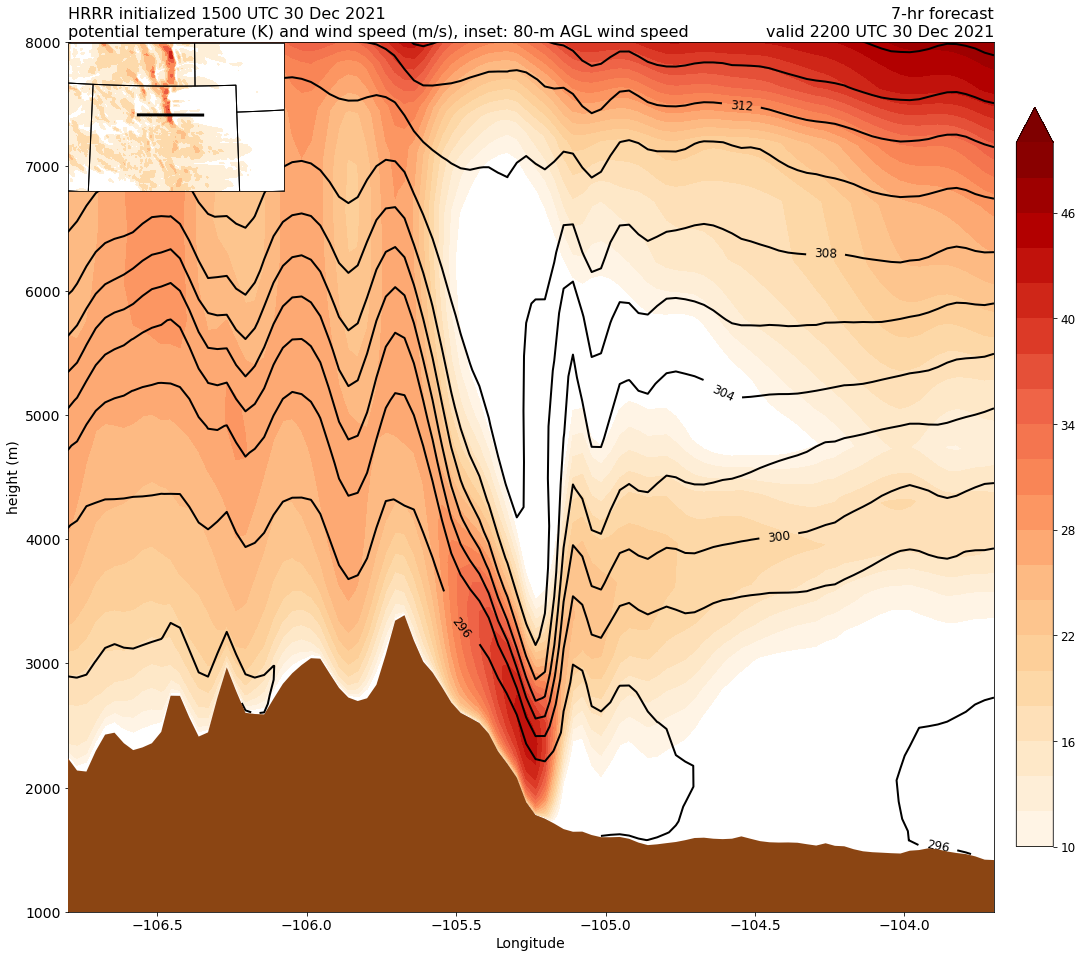

In [13]:
# Define the figure object and primary axes
fig = plt.figure(figsize=(20,16))
ax = plt.axes()

## color fill wind speed
wspd_contour = ax.contourf(cross['longitude2d'], cross['gh'], cross['wspd'],
                          levels=np.arange(10,52,2), cmap=get_cmap("OrRd"), extend='max')

# Add the color bar
cb1 = fig.colorbar(wspd_contour, ax=ax, shrink=.85, pad=0.02)
cb1.ax.tick_params(labelsize=12)

## plot isentropes
theta_contour = ax.contour(cross['longitude2d'], cross['gh'], cross['theta'],
                           levels=np.arange(250, 450, 2), colors='k', linewidths=2)

theta_contour.clabel(theta_contour.levels[1::2], fontsize=12, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

## plot terrain height
ax.fill_between(cross['longitude'], cross['orog'], 0,
               #where=cross['sp'].values <= 100000., 
                facecolor='saddlebrown',
               interpolate=True, zorder=10)

# Set y-axis limit
ax.set_ylim(1000,8000)
## Set the x-axis and  y-axis labels
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("height (m)", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

#### now add an inset in the upper left
ax_inset = fig.add_axes([0.125, 0.74, 0.15, 0.15], projection=plotcrs)
ax_inset.set_extent((-110, -100, 37., 42.5))

## 80-m wind speed
ax_inset.contourf(data.longitude, data.latitude, data_80m_subset.wspd, levels,
             transform=ccrs.PlateCarree(), extend='max', transform_first=True,
             cmap=get_cmap("OrRd"))

# Plot the path of the cross section
ax_inset.plot(cross['longitude'], cross['latitude'], c='k', zorder=10, 
        linewidth=3, transform=ccrs.PlateCarree())

# Add geographic features
ax_inset.coastlines('50m', edgecolor='black', linewidth=0.75)
ax_inset.add_feature(cfeature.STATES, linewidth=1)

# Set the titles and axes labels
ax_inset.set_title('')


# Plot Titles
ax.set_title("HRRR initialized "+init.strftime("%H%M UTC %d %b %Y")+"\npotential temperature (K) and wind speed (m/s), inset: 80-m AGL wind speed",
          loc='left', fontsize=16)
ax.set_title(str(lead)+"-hr forecast\nvalid "+vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)

fig.savefig("xsec_wspd_hrrr_"+init.strftime("%Y%m%d%H")+"_f"+str(lead).zfill(3)+".png",
           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

plt.show()

plt.close('all')

### Or if you prefer pressure as the vertical coordinate, that's possible too

/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_61695/1010561682.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(1000, 200, -100))


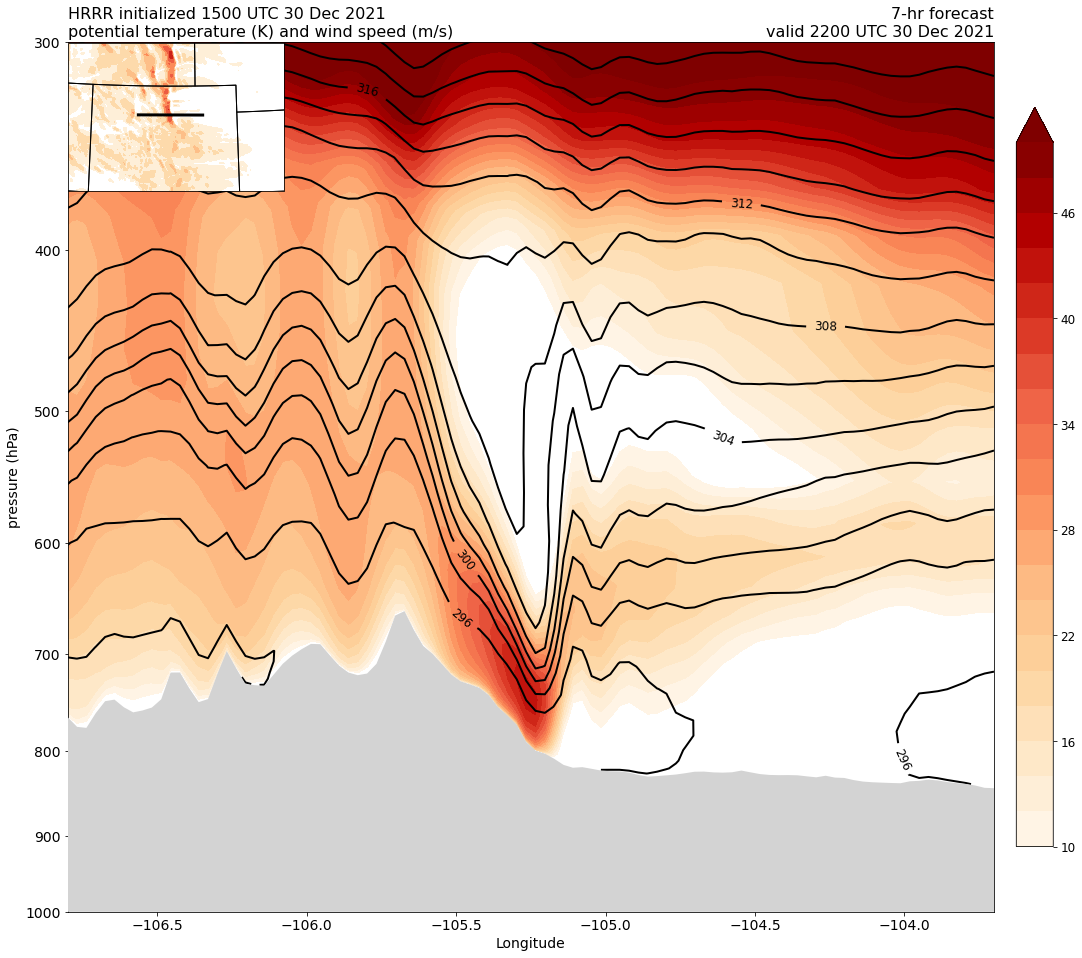

In [14]:
# Define the figure object and primary axes
fig = plt.figure(figsize=(20,16))
ax = plt.axes()

## color fill wind speed
wspd_contour = ax.contourf(cross['longitude2d'], cross['pres']/100., cross['wspd'],
                          levels=np.arange(10,52,2), cmap=get_cmap("OrRd"), extend='max')


# Add the color bar
cb1 = fig.colorbar(wspd_contour, ax=ax, shrink=.85, pad=0.02)
cb1.ax.tick_params(labelsize=12)

## plot isentropes
theta_contour = ax.contour(cross['longitude2d'], cross['pres']/100., cross['theta'],
                           levels=np.arange(250, 450, 2), colors='k', linewidths=2)

theta_contour.clabel(theta_contour.levels[1::2], fontsize=12, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

## plot terrain height
ax.fill_between(cross['longitude'], cross['sp']/100., 1000,
               where=cross['sp'].values <= 100000., facecolor='lightgrey',
               interpolate=True, zorder=10)

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 200, -100))
#ax.set_ylim(cross['isobaric'].max(), cross['isobaric'].min())
ax.set_ylim(1000,300)
ax.set_yticks(np.arange(1000, 200, -100))
# Set the x-axis and  y-axis labels
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("pressure (hPa)", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

#### now add an inset in the upper left
ax_inset = fig.add_axes([0.125, 0.74, 0.15, 0.15], projection=plotcrs)
ax_inset.set_extent((-110, -100, 37., 42.5))

## 80-m wind speed
ax_inset.contourf(data.longitude, data.latitude, data_80m_subset.wspd, levels,
             transform=ccrs.PlateCarree(), extend='max', transform_first=True,
             cmap=get_cmap("OrRd"))

# Plot the path of the cross section
ax_inset.plot(cross['longitude'], cross['latitude'], c='k', zorder=10, 
        linewidth=3, transform=ccrs.PlateCarree())

# Add geographic features
ax_inset.coastlines('50m', edgecolor='black', linewidth=0.75)
ax_inset.add_feature(cfeature.STATES, linewidth=1)

# Set the titles and axes labels
ax_inset.set_title('')


# Plot Titles
ax.set_title("HRRR initialized "+init.strftime("%H%M UTC %d %b %Y")+"\npotential temperature (K) and wind speed (m/s)",
          loc='left', fontsize=16)
ax.set_title(str(lead)+"-hr forecast\nvalid "+vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)

fig.savefig("xsec_wspd_hrrr_pres_"+init.strftime("%Y%m%d%H")+"_f"+str(lead).zfill(3)+".png",
           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

plt.show()

plt.close('all')